In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sla
#import scipy.sparse as sp
#import scipy.sparse.linalg as spla

from radau import gauss_legendre_radau_grid, gauss_legendre_grid



# Gauss-Legendre-Radau x Gauss-Legendre x Fourier grid for H atom

We test a different kind of spherical coordinate spectral method for the H atom.

Coordinates: $(r,\phi,u)$, $u = \cos\theta$ where $\theta$ is the usual elevation angle in spherical coordinates.

$$ x = r \cos\phi (1-u^2)^{1/2} $$
$$ y = r \sin\phi (1-u^2)^{1/2} $$
$$ z = r u $$

Volume element:

$$
dV = r^{2}\, dr\, du\, d\theta.
$$

Kinetic energy form:
$$
t(u,v)
= \int_{0}^{\infty} \int_{-1}^{1} \int_{0}^{2\pi}
    \Big[
      r^{2}\,\partial_{r}u\,\partial_{r}v 
      + (1-u^{2})\,\partial_{u}u\,\partial_{u}v
      + \frac{1}{1-u^{2}}\,\partial_{\theta}u\,\partial_{\theta}v
    \Big]
    \, d\theta\,du\,dr.
$$

We use a Radau grid over $(0,r_\text{max}]$ for the radial direction, which does not include the origin, avoiding the Coulomb singularity. For the u direction we use a GL grid over (-1,1). For $\theta$ we use a Fourier grid. Here, $\hat{H}$ is diagonal in the Fourier basis, so we are left with a 2d grid only.

We know the solutions are spherical harmonics, i.e., the $u$-dependent part of the wavefunction is $P^|m|_l(u) \propto (1-u^2)^{|m|/2} \times$ polynomial. So it is not analytic at $u = \pm 1$. But it is if we factor out $(1-u^2)^{|m|/2}$. I do this in the test below, and we apparently get spectral convergence for different $m$!



In [ ]:
#
# First attempt: Radau grid in r only
#



r_max = 50
n_r = 30

r, w_r, D_r = gauss_legendre_radau_grid(0, r_max, n_r)

T = 0.5 * D_r.T @ np.diag(w_r * r**2) @ D_r
V = np.diag(-1 / r) @ np.diag(w_r * r**2)
S = np.diag(w_r * r**2)

#L = D_r @ D_r + np.diag(2 / r) @ D_r 
E, Psi = sla.eigh(T + V, S)
idx = np.argsort(E)
E = E[idx]
Psi = Psi[:, idx]
print("Computed energies (a.u.):", E[:5])


Computed energies (a.u.): [-0.5        -0.125      -0.05555556 -0.03131618 -0.02175054]


In [ ]:

#
# Second attempt: Radau grid in r, Legendre grid in theta.
# This works, but convergence is slow for higher m.
#

r_max = 30
n_r = 50
n_u = 40

r, w_r, D_r = gauss_legendre_radau_grid(0, r_max, n_r)
u, w_u, D_u = gauss_legendre_grid(-1, 1, n_u)

R, U = np.meshgrid(r, u, indexing='ij')
W_r, W_u = np.meshgrid(w_r, w_u, indexing='ij')

m = 0

T = 0.5 * (np.kron(D_r.T @ np.diag(w_r*r**2) @ D_r, np.diag(w_u)) + np.kron(np.diag(w_r), D_u.T @ np.diag((1-u**2)*w_u) @ D_u))
T_theta = 0.5 * m**2 * np.kron(np.diag(w_r), np.diag((1-u**2)**(-1)*w_u))

V = -np.kron(np.diag(w_r * r), np.diag(w_u))
S = np.kron(np.diag(w_r * r**2), np.diag(w_u))



# Hydrogen atom Hamiltonian
# Eigenvalue problem
E, Psi = sla.eigh(T + T_theta +  V, S) #spla.eigsh(sp.csr_matrix(H), k=5, which='SM')
Psi = Psi.reshape((n_r, n_u, -1))
print("Lowest hydrogen atom energy levels (a.u.):", E[:10])






Lowest hydrogen atom energy levels (a.u.): [-0.5        -0.125      -0.125      -0.05575409 -0.05568128 -0.05559553
 -0.03541501 -0.03518547 -0.03447008 -0.03299693]


In [ ]:
#
# Third attempt: Reduced wavefunction Psi = (1-u**2)**(|m|/2) * Psi_red
# This works better for higher m, we apparently obtain spectral convergence.
#

r_max = 30
n_r = 50
n_u = 10

r, w_r, D_r = gauss_legendre_radau_grid(0, r_max, n_r)
u, w_u, D_u = gauss_legendre_grid(-1, 1, n_u)

R, U = np.meshgrid(r, u, indexing='ij')
W_r, W_u = np.meshgrid(w_r, w_u, indexing='ij')

m = 0
m2 = np.abs(m)/2

T = 0.5 * (np.kron(D_r.T @ np.diag(w_r*r**2) @ D_r, np.diag((1-u**2)**np.abs(m))*w_u) \
    + np.kron(np.diag(w_r), D_u.T @ np.diag((1-u**2)**(np.abs(m)+1)*w_u) @ D_u) \
    - np.kron(np.diag(w_r), D_u.T @ np.diag((m2 *  (1-u**2)**(np.abs(m))*2*u*w_u))) \
    - np.kron(np.diag(w_r), np.diag((m2 *  (1-u**2)**(np.abs(m))*2*u*w_u)) @ D_u)  \
    + np.kron(np.diag(w_r), np.diag((m2**2 *  (1-u**2)**(np.abs(m)-1)*4*u**2*w_u))))
T_theta = 0.5 * m**2 * np.kron(np.diag(w_r), np.diag((1-u**2)**(np.abs(m)-1)*w_u))

V = -np.kron(np.diag(w_r * r), np.diag(w_u * (1-u**2)**(np.abs(m))))
S = np.kron(np.diag(w_r * r**2), np.diag(w_u * (1-u**2)**(np.abs(m))))


#print(R.shape)



# Hydrogen atom Hamiltonian
# Eigenvalue problem
E, Psi_red = sla.eigh(T + T_theta +  V, S) #spla.eigsh(sp.csr_matrix(H), k=5, which='SM')
#E, Psi_red = spla.eigsh(sp.csr_matrix(T + T_theta +  V), k=20, M=sp.csr_matrix(S), which='SM')
#idx = np.argsort(E)
#E = E[idx]
#Psi_red = Psi_red[:, idx].reshape((n_r, n_u, -1))
Psi_red = Psi_red.reshape((n_r, n_u, -1))
print("Lowest hydrogen atom energy levels (a.u.):", E[:10])





Lowest hydrogen atom energy levels (a.u.): [-0.5        -0.125      -0.125      -0.05575409 -0.05568128 -0.05559553
 -0.03541501 -0.03518547 -0.03447008 -0.03299693]


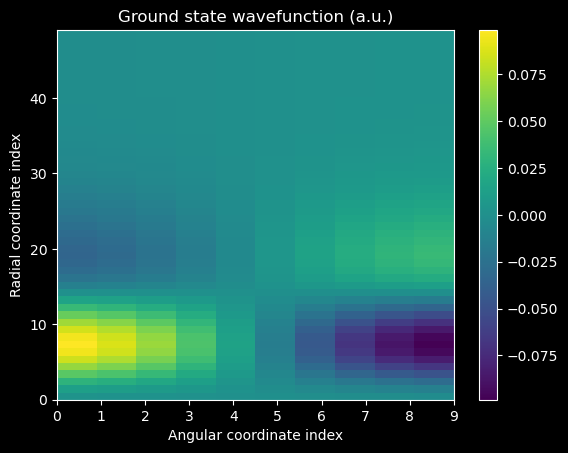

In [113]:
# Pick the j-th eigenstate (for this m), and "normalize" to positive integral
j = 4
Psi = (1 - U**2)**(np.abs(m)/2) * Psi_red[...,j].real
integral = np.sum(Psi * W_r * W_u)
if integral < 0:
    Psi *= -1

plt.figure()
plt.imshow(Psi, extent=(0, n_u-1, 0, n_r-1), origin='lower', aspect='auto')
plt.colorbar()
plt.title("Ground state wavefunction (a.u.)")
plt.xlabel("Angular coordinate index")
plt.ylabel("Radial coordinate index")
plt.show()
    